In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

There are several ways to measure wind speeds. Well known ones are in meters per second (m/s), in knots and the Beaufort scale ([https://en.wikipedia.org/wiki/Beaufort_scale](https://en.wikipedia.org/wiki/Beaufort_scale)). The Beaufort scale is nowadays used rarely officially, but many lay people are still used to this scale. For example in the Netherlands the Beaufort scale is used almost exclusively to get a feel for what a certain wind speed is. Also well known weather sites such as [https://weerplaza.nl](https://weerplaza.nl) used this scale. Some foreign sites such as [https://yr.no](https://yr.no) only report the speed in m/s. This prevents me from get a feel from what the wind speed means. Let's try to do something about that.

We start with the formula from Beaufort to m/s from [https://en.wikipedia.org/wiki/Beaufort_scale](https://en.wikipedia.org/wiki/Beaufort_scale).

In [71]:
def bft_to_ms(b: np.array):
    """
    Convert Beaufort scale to m/s.
    :param b: Beaufort values
    :return: m/s values
    """
    return 0.836 * b ** (3 / 2)

Let's make a plot to show the relationship.

Text(0, 0.5, 'v (m/s)')

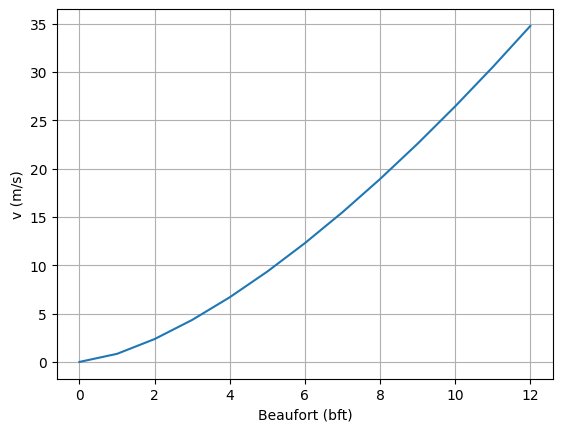

In [72]:
bb = np.arange(0., 13.)
plt.plot(bb, bft_to_ms(bb))
plt.grid()
plt.xlabel("Beaufort (bft)")
plt.ylabel("v (m/s)")

Note that this is a non-linear relationship, although at higher wind speeds it tends to become more linear.

Let's now invert the relationship and obtain the formula from m/s to bft.

In [73]:
def ms_to_bft(ms: np.array) -> np.array:
    """
    Converts m/s to bft (Beaufort).

    The derivations is as follows

    v = 0.836 * b ** (3 / 2)
    v * (1 / 0.836) = b ** (3/2)
    log(v_ms * (1 / 0.836)) = log(b ** (3/2))
    log(v_ms * (1 / 0.836)) = 1.5 * log(b))
    b = exp(log(ms * (1 / 0.836)) / 1.5)
    :param ms: m/s values
    :return: bft values
    """
    return np.exp(np.log(ms * (1 / 0.836)) / 1.5)

Let's also plot this relationship.

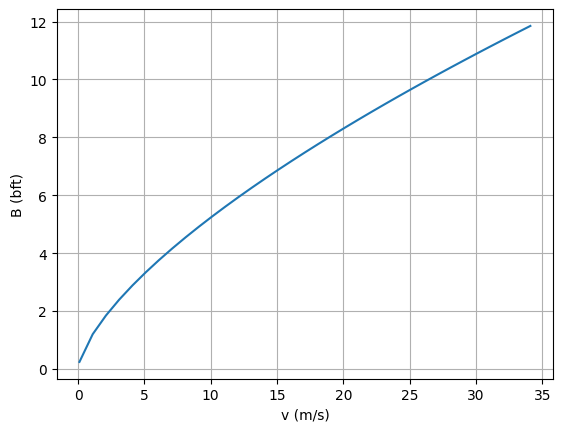

In [74]:
vv = np.arange(0.1, 35)
bb = ms_to_bft(vv)
plt.plot(vv, bb)
plt.xlabel("v (m/s)")
plt.ylabel("B (bft)")
plt.grid()

The relationship is nice, but bringing a chart with you always or trying to remember the formula is annoying. Our approach will be to find a good approximation for the relationship. Because the relationship is non-linear we will use a piecewise linear approximation. Let's start with low wind speeds (up to 12 m/s or 6 bft).

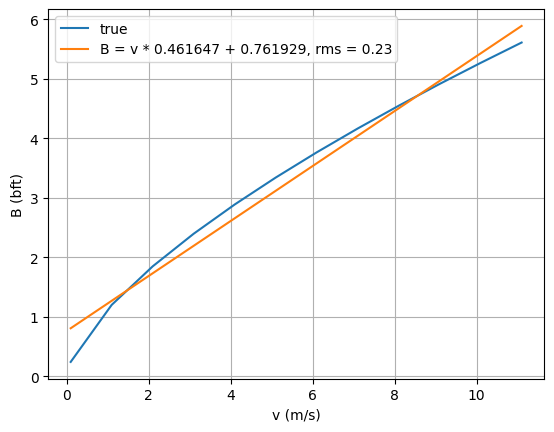

In [75]:
vv = np.arange(0.1, 12)
bb = ms_to_bft(vv)
fig, ax = plt.subplots()
ax.plot(vv, bb, label="true")
a, b = np.polyfit(vv, bb, 1)
approx = vv * a + b


def root_mean_square(in1:np.array, in2:np.array):
    return np.sqrt(np.mean((in1 - in2) ** 2))

ax.plot(vv, approx, label=f"B = v * {a:.6f} + {b:.6f}, rms = {root_mean_square(approx, bb) :.2f}")
ax.legend()
ax.set_xlabel("v (m/s)")
ax.set_ylabel("B (bft)")
ax.grid()

Using a linear (first order) model gives a reasonable fit (measured by the root mean square error [rms]). But remembering so many decimals is annoying too. Let's try if we can do with only 1 decimal.

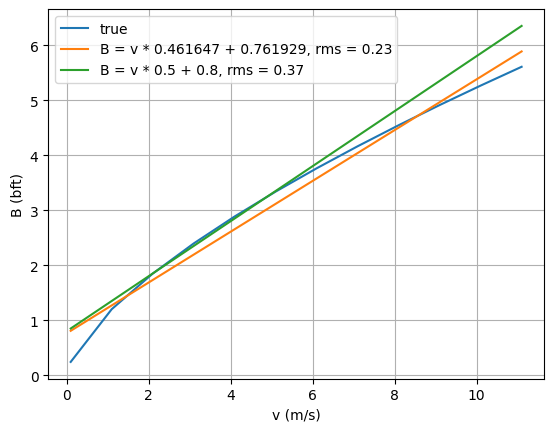

In [76]:
a = np.round(a, 1)
b = np.round(b, 1)
approx = vv * a + b
ax.plot(vv, approx, label=f"B = v * {a} + {b}, rms = {root_mean_square(approx, bb) :.2f}")
ax.legend()
fig

Rounding the coefficients to one decimal gives a reasonable fit but still requires us to remember two numbers. Let's try something by setting both a and b to 0.5

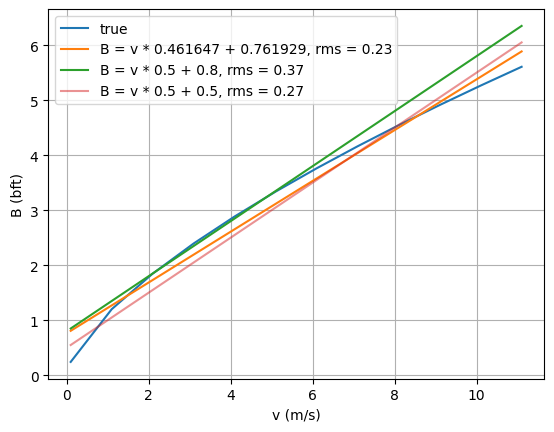

In [77]:
a = .5
b = .5
approx = vv * a + b
ax.plot(vv, approx, label=f"B = v * {a} + {b}, rms = {root_mean_square(approx, bb):.2f}", alpha=0.5)
ax.legend()
fig

That's interesting! Using 0.5 for both a and b gives a better fit than the rounded coefficients. We now have an easy to remember formula: to go from m/s to bft it is times a half plus a half.

The coefficients a=0.5 and b=0.5 where just a guess to get an easy to remember formula. Are they also the optimal one-decimal figures? Let's do a grid search around the original rounded coefficients a=0.5 and b=0.8

coefficients at minimum RMS : a=0.5, b=0.5


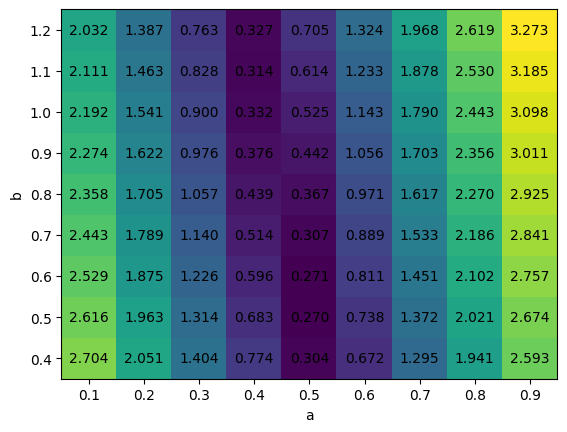

In [78]:
fig = plt.figure()
ax = fig.gca()
a = .5
b = .8
step = .1
X = np.arange(a - 4 * step, a + 4 * step + 0.01, step)
Y = np.arange(b - 4 * step, b + 4 * step, step)
X_grid, Y_grid = np.meshgrid(X, Y)
Z = np.zeros_like(X_grid)
for i, a_ in enumerate(X):
    for j, b_ in enumerate(Y):
        approx = vv * a_ + b_
        rms_ = root_mean_square(approx, bb)
        Z[j, i] = rms_
        # print(a_, b_, rms_)
j_min, i_min = np.unravel_index(Z.argmin(), Z.shape)

pos = ax.pcolormesh(X, Y, Z, vmin=Z.min(), vmax=Z.max(), shading="nearest")
for i, a_ in enumerate(X):
    for j, b_ in enumerate(Y):
        ax.text(a_, b_, f"{Z[j, i]:.3f}", horizontalalignment="center", verticalalignment="center")
ax.set_xlabel("a")
ax.set_ylabel("b")
print(f"coefficients at minimum RMS : a={X[i_min]:.1f}, b={Y[j_min]:.1f}")

# fig.colorbar(pos)

The color table shows that indeed a=0.5 and b=0.5 are the optimal 1-decimal coefficients. This is just a lucky coincidence, but it's good to know that our easy to remember formula is also the most optimal one!

My original motivation for doing this was to study weather forecasts for open water kayaking. Because you should not do that at high wind speeds the low-wind speed approximation is a good heuristic. Still let's see how we can approximate the formula for high wind speeds.

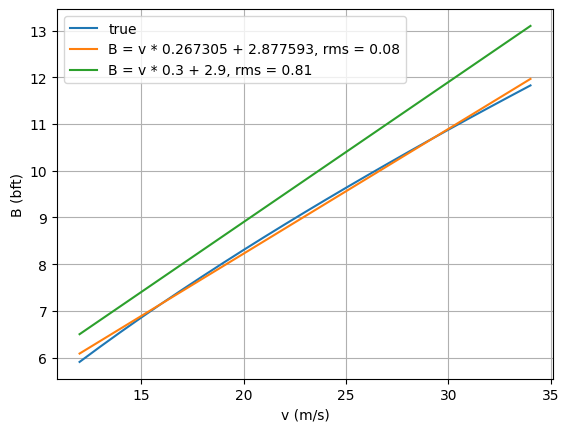

In [79]:
vv = np.arange(12, 35)
bb = ms_to_bft(vv)
fig, ax = plt.subplots()
ax.plot(vv, bb, label="true")
a, b = np.polyfit(vv, bb, 1)
approx = vv * a + b

ax.plot(vv, approx, label=f"B = v * {a:.6f} + {b:.6f}, rms = {root_mean_square(approx, bb) :.2f}")
a = np.round(a, 1)
b = np.round(b, 1)
approx = vv * a + b
ax.plot(vv, approx, label=f"B = v * {a} + {b}, rms = {root_mean_square(approx, bb) :.2f}")
ax.legend()
ax.set_xlabel("v (m/s)")
ax.set_ylabel("B (bft)")
ax.grid()

The 1-decimal rounded linear approximation has quite a large error compared to the unrounded approximation. Let's do a grid search again.

coefficients at minimum RMS : a=0.3, b=2.1


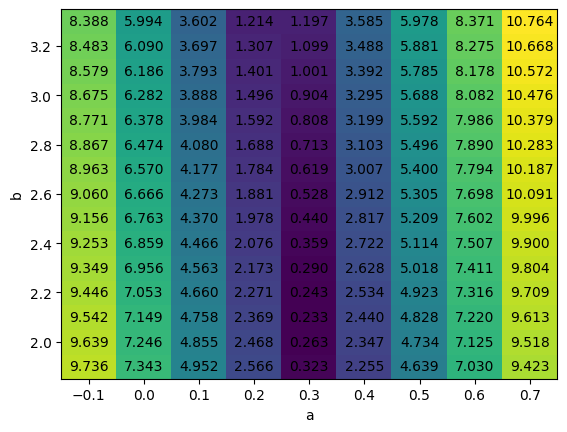

In [80]:
fig = plt.figure()
ax = fig.gca()
step = .1
X = np.arange(a - 4 * step, a + 4 * step + 0.01, step)
Y = np.arange(b - 10 * step, b + 4 * step + 0.01, step)
X_grid, Y_grid = np.meshgrid(X, Y)
Z = np.zeros_like(X_grid)
for i, a_ in enumerate(X):
    for j, b_ in enumerate(Y):
        approx = vv * a_ + b_
        rms_ = root_mean_square(approx, bb)
        Z[j, i] = rms_
        # print(a_, b_, rms_)
j_min, i_min = np.unravel_index(Z.argmin(), Z.shape)

pos = ax.pcolormesh(X, Y, Z, vmin=Z.min(), vmax=Z.max(), shading="nearest")
for i, a_ in enumerate(X):
    for j, b_ in enumerate(Y):
        ax.text(a_, b_, f"{Z[j, i]:.3f}", horizontalalignment="center", verticalalignment="center")
ax.set_xlabel("a")
ax.set_ylabel("b")
print(f"coefficients at minimum RMS : a={X[i_min]:.1f}, b={Y[j_min]:.1f}")

Also for higher wind speeds the optimal 1-decimal coefficients are different from directly rounding the original linear coefficients...

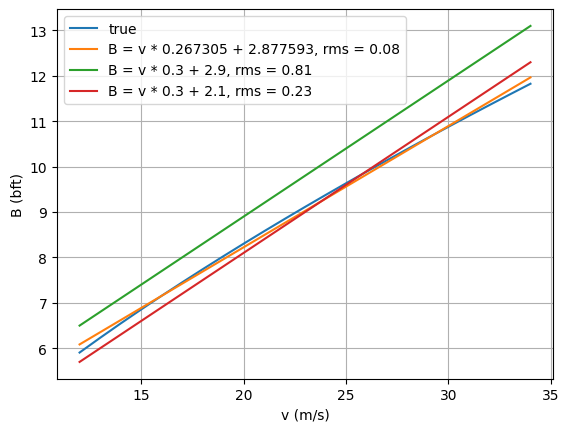

In [81]:
vv = np.arange(12, 35)
bb = ms_to_bft(vv)
fig, ax = plt.subplots()
ax.plot(vv, bb, label="true")
a, b = np.polyfit(vv, bb, 1)
approx = vv * a + b

ax.plot(vv, approx, label=f"B = v * {a:.6f} + {b:.6f}, rms = {root_mean_square(approx, bb) :.2f}")
a = np.round(a, 1)
b = np.round(b, 1)
approx = vv * a + b
ax.plot(vv, approx, label=f"B = v * {a} + {b}, rms = {root_mean_square(approx, bb) :.2f}")
approx = vv * X[i_min] + Y[j_min]
ax.plot(vv, approx, label=f"B = v * {X[i_min]} + {Y[j_min]}, rms = {root_mean_square(approx, bb) :.2f}")
ax.legend()
ax.set_xlabel("v (m/s)")
ax.set_ylabel("B (bft)")
ax.grid()

... and the optimal rounded coefficients show actually quite an accurate fit.

Can we also try to make an easy to remember formula for higher wind speeds, such as divide by 3 add 2?

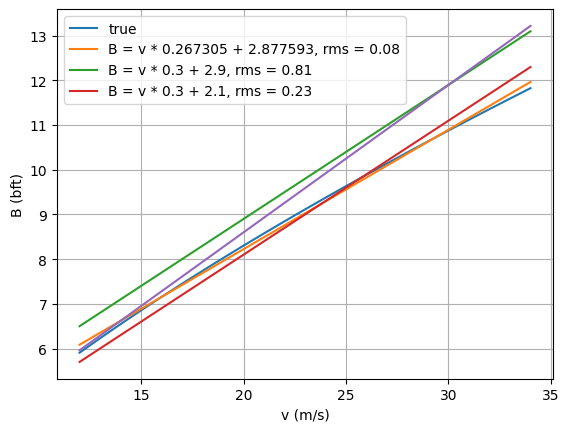

In [82]:
approx = vv * 0.33 + 2.0
ax.plot(vv, approx, label=f"B = v/3 + 2, rms = {root_mean_square(approx, bb) :.2f}")
fig

Divide by 3 add 2 seems not to be a great heuristic.

Let's put this all in one picture.

Text(0, 0.5, 'B (bft)')

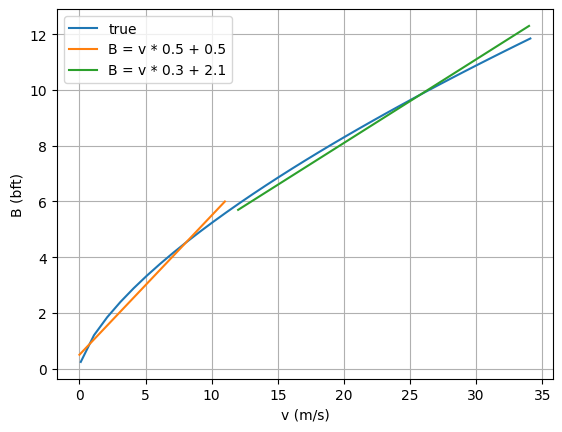

In [83]:
vv = np.arange(0.1, 35)
bb = ms_to_bft(vv)
fig, ax = plt.subplots()
ax.plot(vv, bb, label="true")
ax.grid()
vv_low = np.arange(0, 12)
ax.plot(vv_low, vv_low * 0.5 + 0.5, label=f"B = v * 0.5 + 0.5")
vv_high = np.arange(12, 35)
ax.plot(vv_high, vv_high * 0.3 + 2.1, label=f"B = v * 0.3 + 2.1")
ax.legend()
ax.set_xlabel("v (m/s)")
ax.set_ylabel("B (bft)")